## 9 - Code zur Vorlesung Explainable AI mit LIME und SHAP

Das folgende Notebook basiert auf:
1) Diabetes2 Datensatz: https://www.kaggle.com/datasets/cjboat/diabetes2 
2) Introduction to LIME & SHAP: https://www.kaggle.com/code/momtajhossainmow/introduction-to-lime-shap (Lizenz: Apache 2.0)

In [10]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [11]:
# workaround to show html rendering in VSCode notebooks
import sys
from IPython import display
sys.modules['IPython.core.display'] = display

### Diabetes2 Datensatz Exploration ###

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cjboat/diabetes2")

print("Path to dataset files:", path)

Path to dataset files: /Users/winkelmannsv/.cache/kagglehub/datasets/cjboat/diabetes2/versions/1


In [13]:
df = pd.read_csv(os.path.join(path, "diabetes(2).csv"))
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
df['Outcome'].unique()

array([1, 0])

Die Spalte Outcome ist unser "Label", welches unser Black Box-Modell, auf Basis der anderen Features, vorhersagen kann:
- 1: Hat Diabetes
- 0: Hat kein Diabetes

In [15]:
print(f"Unser Datensatz hat {df.shape[0]} Samples mit {df.shape[1]-1} Features.")

Unser Datensatz hat 768 Samples mit 8 Features.


In [16]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

### Modell Training ###

In [17]:
# splitting the data into independent and dependent variables
x = df.drop(columns=['Outcome'])
y = df['Outcome']

# dividing the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [18]:
# building the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)

In [19]:
# importing the necessary libraries
from sklearn.model_selection import GridSearchCV

# creating a dictionary and list of their values to optimize the model
params = {
    'n_estimators' : [100, 500, 1000],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10],
}

# intiating a grid search to find the most optimum parameters
grid_search = GridSearchCV(model, params, cv=5)

# fitting the training data
grid_search.fit(x_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, ...], 'n_estimators': [100, 500, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,500


In [20]:
# obtaining the best model
model = grid_search.best_estimator_

# fitting the training data
model.fit(x_train, y_train)

# obtaining the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       123
           1       0.66      0.68      0.67        69

    accuracy                           0.76       192
   macro avg       0.74      0.74      0.74       192
weighted avg       0.76      0.76      0.76       192



### LIME

#### Generelle Idee ####
wir variieren einen konkreten Datenpunkt und LIME trainiert darauf basierend ein interpretierbares Modell, welches uns unseren Datenpunkt lokal erklärt.

#### Vorgehensweise ####
1) Datensatz in der Nachbarschaft unseres Datenpunktes generieren
2) (Black Box)-Modell zur Vorhersage für den gesamten Datensatz ausführen
3) Interpretierbares Modell (z.B. Entscheidungsbaum, Regressionsmodell) mit Datensatz und Modell-Vorhersage trainieren
4) Interpretierbares Modell zur Erklärung des Datenpunktes nutzen


In [21]:
import lime
from lime import lime_tabular

Wir müssen nun unseren LimeTabularExplainer initialisieren, dafür benötigen wir:
1) Datensatz: wir werden es uns hier einfach machen, und anstatt eines speziellen Datensatzes zu generieren einfach unseren Trainingsdatensatz nehmen, da wir diesen haben.
2) Feature Names: wir nehmen alle Features in unser interpretierbares Modell
3) Class Names: unsere Vorhersage Klassen
4) Modus: hier ein Klassifikationsproblem

In [22]:
lime_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train), 
                                                    feature_names=x_train.columns, 
                                                    class_names=['No Diabetes', 'Has Diabetes'], 
                                                    mode='classification')

In [23]:
data_row_1 = x_test.iloc[1]
data_row_1

Pregnancies                   2.000
Glucose                     112.000
BloodPressure                75.000
SkinThickness                32.000
Insulin                       0.000
BMI                          35.700
DiabetesPedigreeFunction      0.148
Age                          21.000
Name: 324, dtype: float64

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

explanation = lime_explainer.explain_instance(data_row=data_row_1, predict_fn=model.predict_proba, num_features=8)
# printing out the explanation
explanation.show_in_notebook(show_table = True, show_all = True)

/Users/winkelmannsv/git/aki/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [25]:
d = {'Pregnancies': [1.0], 
     'Glucose': [150.0], 
     'BloodPressure': [120.0], 
     'SkinThickness': [30.0], 
     'Insulin': [0.0], 
     'BMI': [45.0],
     'DiabetesPedigreeFunction': [0.148],
     'Age': [75.0]}
data_row_2 = pd.DataFrame(data=d).iloc[0]

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

explanation = lime_explainer.explain_instance(data_row=data_row_2, predict_fn=model.predict_proba, num_features=8)
# printing out the explanation
explanation.show_in_notebook(show_table = True, show_all = True)

/Users/winkelmannsv/git/aki/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### SHAP ###

In [59]:
import shap
explainer = shap.TreeExplainer(model, x)
shap_values = explainer.shap_values(x)
shap.initjs()

 99%|===================| 1515/1536 [00:40<00:00]        

Wie sich der SHAP-Werte pro Feature berechnet können wir uns im dependence plot anschauen:

<Figure size 640x480 with 0 Axes>

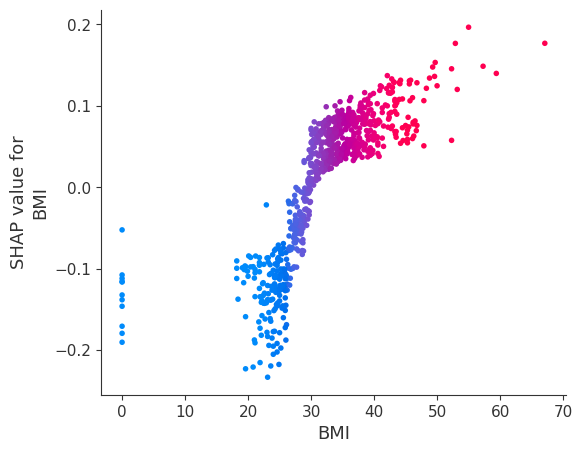

In [67]:
figure = plt.figure()
shap.dependence_plot('BMI', shap_values[:, :, 1], x, interaction_index="BMI")

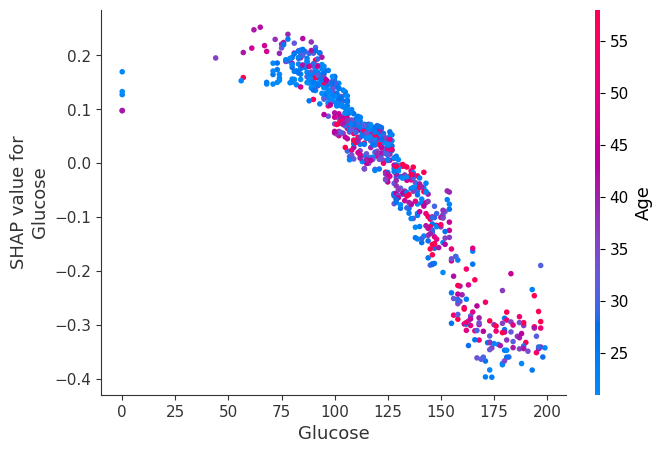

In [70]:
shap.dependence_plot('Glucose', shap_values[:, :, 0], x)

Wie jedes Feature auf die entsprechende Klasse einzahlt können wir im summary_plot sehen:

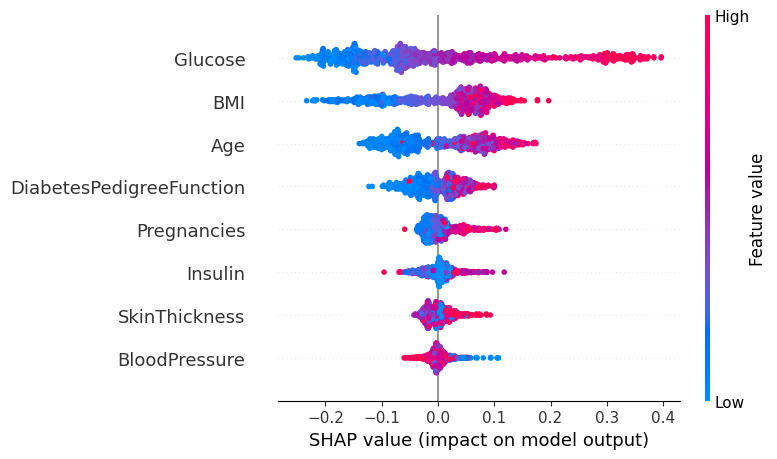

In [72]:
shap.summary_plot(shap_values[:, :, 1], x)

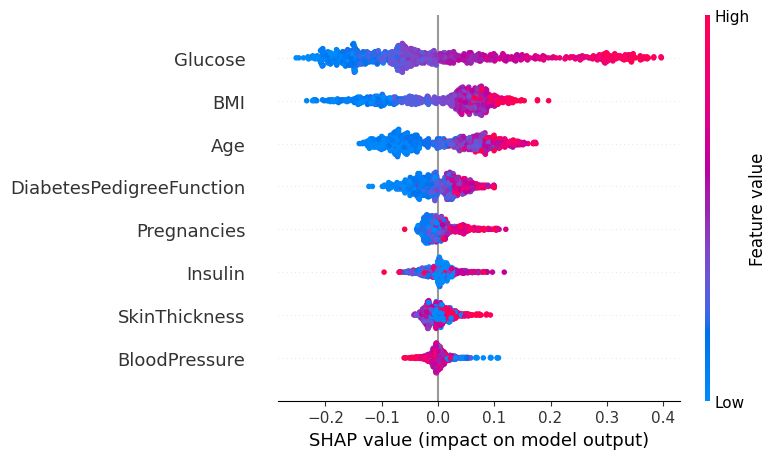

In [74]:
shap.summary_plot(shap_values[:, :, 1], x)